In [2]:
import wgpu
from functools import reduce
import numpy as np
import matplotlib.pyplot as plt
from pprint import pprint
import math
import time

In [3]:
adapter_0 = wgpu.gpu.request_adapter_sync(power_preference="high-performance")
device_0 = adapter_0.request_device_sync(
    required_features=[wgpu.FeatureName.timestamp_query]
)
pprint(adapter_0.info)

adapter_1 = wgpu.gpu.request_adapter_sync(power_preference="low-power")
device_1 = adapter_1.request_device_sync(
    required_features=[wgpu.FeatureName.timestamp_query]
)
pprint(adapter_1.info)

{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}
{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}


In [4]:
if 1:
    adapter = adapter_0
    device = device_0
else:
    adapter = adapter_1
    device = device_1

pprint(adapter.info)

{'adapter_type': 'IntegratedGPU',
 'architecture': '',
 'backend_type': 'Vulkan',
 'description': '24.12.1 (AMD proprietary shader compiler)',
 'device': 'AMD Radeon(TM) Graphics',
 'device_id': 5761,
 'vendor': 'AMD proprietary driver',
 'vendor_id': 4098}


In [5]:
# x, y, z
#grid_size = [128, 128, 128]
grid_size = [17, 107, 128]
#grid_size = [16*10, 16*8, 16]
#grid_size = [512, 256, 128]
#grid_size = [128, 256, 512]
# grid_size = [16, 128, 2048]
#grid_size = [16, 1024, 1024]
# grid_size = [66, 109, 25]
total_cells = grid_size[0]*grid_size[1]*grid_size[2]

print(f"grid_size={grid_size}")
print(f"total_cells={total_cells}")

# create cpu side data
n_dims = 3
x_cpu = np.zeros(grid_size + [n_dims,], dtype=np.float32)
y_cpu = np.zeros(grid_size + [n_dims,], dtype=np.float32)

x = np.reshape(x_cpu, (n_dims*total_cells,))
x[:] = (-1.0*np.arange(0, n_dims*total_cells, dtype=np.float32) + 0.5) % 0.88490

# Create buffer objects, input buffer is mapped.
x_gpu = device.create_buffer_with_data(data=x_cpu.data, usage=wgpu.BufferUsage.STORAGE)
y_gpu = device.create_buffer(
    size=y_cpu.data.nbytes,
    usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC
)
y_gpu_readback = device.create_buffer(
    size=y_cpu.data.nbytes,
    usage=wgpu.BufferUsage.MAP_READ | wgpu.BufferUsage.COPY_DST
)

# Setup layout and bindings
binding_layouts = [
    {
        "binding": 0,
        "visibility": wgpu.ShaderStage.COMPUTE,
        "buffer": {
            "type": wgpu.BufferBindingType.read_only_storage,
        },
    },
    {
        "binding": 1,
        "visibility": wgpu.ShaderStage.COMPUTE,
        "buffer": {
            "type": wgpu.BufferBindingType.storage,
        },
    },
]

# Put everything together
bind_group_layout = device.create_bind_group_layout(entries=binding_layouts)
pipeline_layout = device.create_pipeline_layout(bind_group_layouts=[bind_group_layout])

grid_size=[17, 107, 128]
total_cells=232832


### SEARCH ###
local_size=[1, 1, 16]
dispatch_size=[17, 107, 8]
grid_size=[17, 107, 128]
global_size=[17, 107, 128]
Exceeded timeout limit for sample collection
cell_count=232832
delta_avg=21.206 us
cell_rate=10979.534 M/s
flops=131.754 GFlops
total_samples=452
### SEARCH ###
local_size=[1, 1, 32]
dispatch_size=[17, 107, 4]
grid_size=[17, 107, 128]
global_size=[17, 107, 128]
cell_count=232832
delta_avg=15.192 us
cell_rate=15325.961 M/s
flops=183.912 GFlops
total_samples=512
### SEARCH ###
local_size=[1, 1, 64]
dispatch_size=[17, 107, 2]
grid_size=[17, 107, 128]
global_size=[17, 107, 128]
cell_count=232832
delta_avg=15.520 us
cell_rate=15002.062 M/s
flops=180.025 GFlops
total_samples=512
### SEARCH ###
local_size=[1, 1, 128]
dispatch_size=[17, 107, 1]
grid_size=[17, 107, 128]
global_size=[17, 107, 128]
cell_count=232832
delta_avg=11.880 us
cell_rate=19598.653 M/s
flops=235.184 GFlops
total_samples=512
### SEARCH ###
local_size=[1, 2, 8]
dispatch_size=[17, 54, 16]
grid_size=[17, 107, 128

Text(0, 0.5, 'Count')

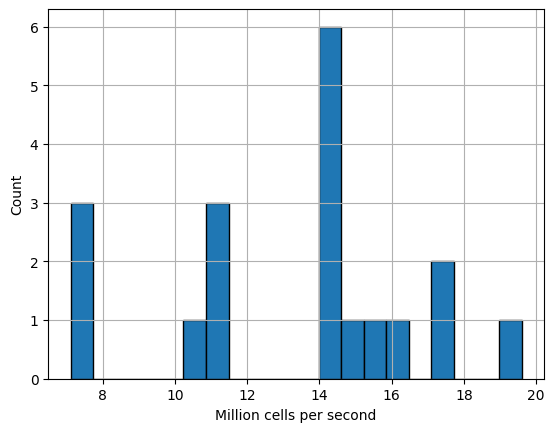

In [6]:
benchmarks = []
max_samples = 512
min_samples = 8
sampling_timeout_ms = 10
flops_per_cell = 12

best_x_time = None
z_fail_threshold = 2
y_fail_threshold = 1
x_fail_threshold = 1
is_fail_threshold = True

x_fail = 0
for x in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512):
    best_y_time = None    
    y_fail = 0
    for y in (1, 2, 4, 8, 16, 32, 64, 128, 256, 512):
        best_z_time = None
        z_fail = 0
        for z in (8, 16, 32, 64, 128, 256, 512, 1024, 2048):
            if x > grid_size[0]: continue
            if y > grid_size[1]: continue
            if z > grid_size[2]: continue
            if x*y*z > 1024: continue
            if x*y*z < 16: continue
               
            # create shader
            local_size = [x,y,z]
            dispatch_size = [math.ceil(g/l) for g,l in zip(grid_size, local_size)]
            global_size = [d*l for d,l in zip(dispatch_size, local_size)]

            print("### SEARCH ###")
            print(f"local_size={local_size}")
            print(f"dispatch_size={dispatch_size}")
            print(f"grid_size={grid_size}")
            print(f"global_size={global_size}")
            
            shader_source = f"""
            @group(0) @binding(0)
            var<storage,read> x: array<f32>;
            
            @group(0) @binding(1)
            var<storage,read_write> y: array<f32>;
            
            fn get_offset(i: vec3<u32>) -> u32 {{
                let x: u32 = i.x % {grid_size[0]};
                let y: u32 = i.y % {grid_size[1]};
                let z: u32 = i.z % {grid_size[2]};
                let offset: u32 = z + y*{grid_size[2]} + x*{grid_size[2]*grid_size[1]};
                return offset*{n_dims};
            }}
            
            @compute
            @workgroup_size({",".join(map(str, local_size))})
            fn main(@builtin(global_invocation_id) i0: vec3<u32>) {{
                if (i0.x >= {grid_size[0]}) {{ return; }}
                if (i0.y >= {grid_size[1]}) {{ return; }}
                if (i0.z >= {grid_size[2]}) {{ return; }}
                let i = get_offset(i0);
                let iz = get_offset(i0 + vec3(0,0,1));
                let iy = get_offset(i0 + vec3(0,1,0));
                let ix = get_offset(i0 + vec3(1,0,0));
                y[i+0] += (x[i+2]-x[iy+2]) - (x[i+1]-x[iz+1]);
                y[i+1] += (x[i+0]-x[iz+0]) - (x[i+2]-x[ix+2]);
                y[i+2] += (x[i+1]-x[ix+1]) - (x[i+0]-x[iy+0]);
            }}
            """
            
            cshader = device.create_shader_module(code=shader_source)
            
            # Create and run the pipeline
            compute_pipeline = device.create_compute_pipeline(
                layout=pipeline_layout,
                compute={"module": cshader, "entry_point": "main"},
            )
            
            """
            Create a QuerySet to store the 'beginning_of_pass' and 'end_of_pass' timestamps.
            Set the 'count' parameter to 2, as this set will contain 2 timestamps.
            """
            query_count = 2
            query_set = device.create_query_set(type=wgpu.QueryType.timestamp, count=query_count)
            
            """
            Create the buffer to store our query results.
            Each timestamp is 8 bytes. We mark the buffer usage to be QUERY_RESOLVE,
            as we will use this buffer in a resolve_query_set call later.
            """
            query_buf = device.create_buffer(
                size=8*query_set.count,
                usage=wgpu.BufferUsage.QUERY_RESOLVE | wgpu.BufferUsage.COPY_SRC,
            )

            y_gpu = device.create_buffer(
                size=y_cpu.data.nbytes,
                usage=wgpu.BufferUsage.STORAGE | wgpu.BufferUsage.COPY_SRC
            )
            
            # Pass our QuerySet and the indices into it, where the timestamps will be written.
            samples = []
            total_ns = 0
            for sample_idx in range(max_samples):
                command_encoder = device.create_command_encoder()
                
                compute_pass_0 = command_encoder.begin_compute_pass(
                    timestamp_writes={
                        "query_set": query_set,
                        "beginning_of_pass_write_index": 0,
                        "end_of_pass_write_index": 1,
                    }
                )
                compute_pass_0.set_pipeline(compute_pipeline)
                bindings = [
                    {
                        "binding": 0,
                        "resource": {"buffer": x_gpu, "offset": 0, "size": x_gpu.size},
                    },
                    {
                        "binding": 1,
                        "resource": {"buffer": y_gpu, "offset": 0, "size": y_gpu.size},
                    },
                ]
                bind_group = device.create_bind_group(layout=bind_group_layout, entries=bindings)
                compute_pass_0.set_bind_group(0, bind_group)
                compute_pass_0.dispatch_workgroups(*dispatch_size)  # x y z
                compute_pass_0.end()
                
                # Resolve our queries, and store the results in the destination buffer we created above.
                command_encoder.resolve_query_set(
                    query_set=query_set,
                    first_query=0,
                    query_count=query_count,
                    destination=query_buf,
                    destination_offset=0,
                )
                command_encoder.copy_buffer_to_buffer(
                    source=y_gpu,
                    source_offset=0,
                    destination=y_gpu_readback,
                    destination_offset=0,
                    size=y_cpu.data.nbytes
                )
                device.queue.submit([command_encoder.finish()])
                
                """
                Read the query buffer to get the timestamps.
                Index 0: beginning timestamp
                Index 1: end timestamp
                """
                timestamps_ns = device.queue.read_buffer(query_buf).cast("Q").tolist()
                delta_ns = timestamps_ns[1] - timestamps_ns[0]
                samples.append(delta_ns)
                total_ns += delta_ns
                if sample_idx >= min_samples and total_ns > sampling_timeout_ms*1e6:
                    print("Exceeded timeout limit for sample collection")
                    break

            delta_ns = np.array(samples)
            delta_ns_overall = np.median(delta_ns)
            cell_rate = total_cells / (delta_ns_overall*1e-9)
            flops = cell_rate*flops_per_cell
            print(f"cell_count={total_cells}")
            print(f"delta_avg={delta_ns_overall*1e-3:.3f} us")
            print(f"cell_rate={cell_rate*1e-6:.3f} M/s")
            print(f"flops={flops*1e-9:.3f} GFlops")
            print(f"total_samples={delta_ns.shape[0]}")

            # Read result
            y_gpu_readback.map_sync(wgpu.MapMode.READ, 0, y_cpu.data.nbytes)
            y_gpu_pred_memview = y_gpu_readback.read_mapped(buffer_offset=0, size=y_cpu.data.nbytes, copy=True)
            y_gpu_pred = np.frombuffer(y_gpu_pred_memview, dtype=np.float32)
            y_gpu_pred = np.reshape(y_gpu_pred, grid_size+[n_dims,])
            y_gpu_readback.unmap()
            
            benchmarks.append((local_size, delta_ns_overall, delta_ns, y_gpu_pred))

            if best_z_time == None or best_z_time > delta_ns_overall:
                best_z_time = delta_ns_overall
                z_fail = 0
            else:
                z_fail += 1
            if z_fail >= z_fail_threshold and is_fail_threshold:
                print("Early exiting z loop")
                break
        if best_z_time == None: continue
        if best_y_time == None or best_y_time > best_z_time:
            best_y_time = best_z_time
            y_fail = 0
        else:
            y_fail += 1
        if y_fail >= y_fail_threshold and is_fail_threshold:
            print("Early exiting y loop")
            break
    if best_y_time == None: continue
    if best_x_time == None or best_x_time > best_y_time:
        best_x_time = best_y_time
        x_fail = 0
    else:
        x_fail += 1
    if x_fail >= x_fail_threshold and is_fail_threshold:
        print("Early exiting x loop")
        break

local_size, delta_ns_overall, gpu_samples, y_gpu_pred = min(benchmarks, key=lambda x: x[1])
gpu_cell_rate = total_cells / (delta_ns_overall*1e-9)
gpu_flops = gpu_cell_rate*flops_per_cell
print("### SEARCH RESULTS ###")
print(f"best_local_size = {local_size}")
print(f"delta_us = {delta_ns_overall*1e-3:.2f} us")
print(f"gpu_cell_rate = {gpu_cell_rate*1e-6:.3f} M/s")
print(f"gpu_flops={gpu_flops*1e-9:.3f} GFlops")
print(f"samples={gpu_samples.shape[0]}")

_ = plt.hist([total_cells / b[1] for b in benchmarks], bins=20, edgecolor="black")
plt.grid(True)
plt.xlabel("Million cells per second")
plt.ylabel("Count")

In [7]:
def cpu_shader(x, y, wrap_around=True):
    if not wrap_around:
        y[:,:-1,:-1,0] += (x[:,:-1,:-1,2]-x[:,1:,:-1,2]) - (x[:,:-1,:-1,1]-x[:,:-1,1:,1])
        y[:-1,:,:-1,1] += (x[:-1,:,:-1,0]-x[:-1,:,1:,0]) - (x[:-1,:,:-1,2]-x[1:,:,:-1,2])
        y[:-1,:-1,:,2] += (x[:-1,:-1,:,1]-x[1:,:-1,:,1]) - (x[:-1,:-1,:,0]-x[:-1,1:,:,0])
    else:
        y[:,:-1,:,0] += (x[:,:-1,:,2]-x[:,1:,:,2]) 
        y[:,-1,:,0] += (x[:,-1,:,2]-x[:,0,:,2])
        y[:,:,:-1,0] -= (x[:,:,:-1,1]-x[:,:,1:,1])
        y[:,:,-1,0] -= (x[:,:,-1,1]-x[:,:,0,1])
        
        y[:,:,:-1,1] += (x[:,:,:-1,0]-x[:,:,1:,0]) 
        y[:,:,-1,1] += (x[:,:,-1,0]-x[:,:,0,0]) 
        y[:-1,:,:,1] -= (x[:-1,:,:,2]-x[1:,:,:,2])
        y[-1,:,:,1] -= (x[-1,:,:,2]-x[0,:,:,2])
        
        y[:-1,:,:,2] += (x[:-1,:,:,1]-x[1:,:,:,1]) 
        y[-1,:,:,2] += (x[-1,:,:,1]-x[0,:,:,1]) 
        y[:,:-1,:,2] -= (x[:,:-1,:,0]-x[:,1:,:,0])
        y[:,-1,:,2] -= (x[:,-1,:,0]-x[:,0,:,0])


# Calculate the result on the CPU for comparison
y_cpu_pred = np.zeros(y_cpu.shape, dtype=y_cpu.dtype)

cpu_samples = []
for _ in range(gpu_samples.shape[0]):
    start_ns = time.perf_counter_ns()
    cpu_shader(x_cpu, y_cpu_pred, wrap_around=True)
    end_ns = time.perf_counter_ns()
    delta_ns = end_ns - start_ns
    cpu_samples.append(delta_ns)
cpu_delta_ns = np.array(cpu_samples)
cpu_delta_ns_avg = np.mean(cpu_delta_ns)
cpu_cell_rate = total_cells / (cpu_delta_ns_avg*1e-9)
cpu_flops = cpu_cell_rate*flops_per_cell
print(f"cpu_delta_avg={cpu_delta_ns_avg*1e-3:.3f} us")
print(f"cpu_cell_rate={cpu_cell_rate*1e-6:.3f} M/s")
print(f"cpu_flops={cpu_flops*1e-9:.3f} GFlops")
print(f"gpu/cpu = {gpu_cell_rate/cpu_cell_rate:.2f}x")

# Ensure results are the same
error = y_gpu_pred - y_cpu_pred
#error = error[:-1,:-1,:-1,:] # skip last dimension on curl
error_max = np.max(error)
error_min = np.min(error)
error_abs = np.abs(error)
error_avg = np.mean(error) 
error_abs_avg = np.mean(error_abs)

print(f"error_min={error_min:.3e}")
print(f"error_max={error_max:.3e}")
print(f"error_avg={error_avg:.3e}")
print(f"error_abs_avg={error_abs_avg:.3e}")

n_read = 1
print(y_gpu_pred[:n_read, :n_read, :n_read, :])
print(y_cpu_pred[:n_read, :n_read, :n_read, :])
print(y_gpu_pred[-n_read:, -n_read:, -n_read:,:])
print(y_cpu_pred[-n_read:, -n_read:, -n_read:,:])

cpu_delta_avg=1640.907 us
cpu_cell_rate=141.892 M/s
cpu_flops=1.703 GFlops
gpu/cpu = 138.12x
error_min=-5.310e-03
error_max=4.791e-03
error_avg=-3.111e-04
error_abs_avg=3.999e-04
[[[[-200.64793  463.76474  189.95311]]]]
[[[[-200.6467   463.76462  189.95311]]]]
[[[[-390.59857  139.82811 -202.29686]]]]
[[[[-390.5986   139.82812 -202.29688]]]]


In [8]:
from sklearn.neural_network import MLPRegressor
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.svm import LinearSVR
from pygam import LinearGAM, s

feature_names = [
    "workgroup_size.x",
    "workgroup_size.y",
    "workgroup_size.z",
    "dispatch_size.x",
    "dispatch_size.y",
    "dispatch_size.z",
    "workgroup_count",
    "dispatch_count",
    "z_stride",
    "y_stride",
    "yz_stride",
]

def get_x(local_size, grid_size):
    dispatch_size = [int(g/l) for g,l in zip(grid_size, local_size)]
    x, y, z = local_size
    x_skip = x*grid_size[1]*grid_size[2]
    y_skip = y*grid_size[2]
    stride = x_skip + y_skip
    local_count = reduce(lambda x,y: x*y, local_size, 1)
    dispatch_count = reduce(lambda x,y: x*y, dispatch_size, 1)
    
    return [*local_size, *dispatch_size, local_count, dispatch_count, x_skip, y_skip, stride]
    #return [local_count, dispatch_count, x, y, z]

X_train = np.array([get_x(b[0], grid_size) for b in benchmarks])
Y_train = np.array([b[1] for b in benchmarks]).T * 1e-6
Y_train = np.expand_dims(Y_train, axis=1)

def norm(X):
    X_max = np.max(X, axis=0)
    X_min = np.min(X, axis=0)
    R = X_max-X_min
    R[R == 0.0] = 1.0
    return (X-X_min)/R
X_train = norm(X_train)
Y_train = norm(Y_train).ravel()

#model = LinearGAM(s(0, constraints='concave'))
#model = MLPRegressor(hidden_layer_sizes=(32, 64, 32, 16), activation='relu', solver='sgd', max_iter=10000, learning_rate="adaptive")
#model = MLPRegressor(hidden_layer_sizes=(16, 8), activation='relu', solver='sgd', max_iter=10000, learning_rate="adaptive")
#model = DecisionTreeRegressor(min_samples_split=3, max_depth=2)
model = LinearSVR(max_iter=50000)

model.fit(X_train, Y_train)
Y_pred = model.predict(X_train)
Y_err = np.abs(Y_train - Y_pred)
print(np.mean(Y_err))

if model.__class__ == DecisionTreeRegressor:
    plt.figure(figsize=(10, 6))
    _ = plot_tree(model, feature_names=feature_names, fontsize=8)

0.03700629420015537
